# Timeseries Forecasting

This notebook explains how to use `tsfresh` in time series foreacasting.
Make sure you also read through the [documentation](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) to learn more on this feature.

It is basically a copy of the other time series forecasting notebook, but this time using more than one 
stock.
This is conceptionally not much different, but the pandas multi-index magic is a bit advanced :-)

We will use the Google, Facebook and Alphabet stock.
Please find all documentation in the other notebook.

In [22]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.ensemble import AdaBoostRegressor
from datetime import datetime

## Reading the data

In [23]:
df = web.DataReader(["AAPL", "GOOGL", "MSFT"], 'stooq', start='2010-01-01', end=datetime.now())["Close"]
df.head()

Symbols,AAPL,GOOGL,MSFT
Date,,,
2022-09-08,154.45,108.38,258.52
2022-09-07,155.96,109.45,258.09
2022-09-06,154.53,106.81,253.25
2022-09-02,155.81,107.85,256.06
2022-09-01,157.96,109.74,260.40


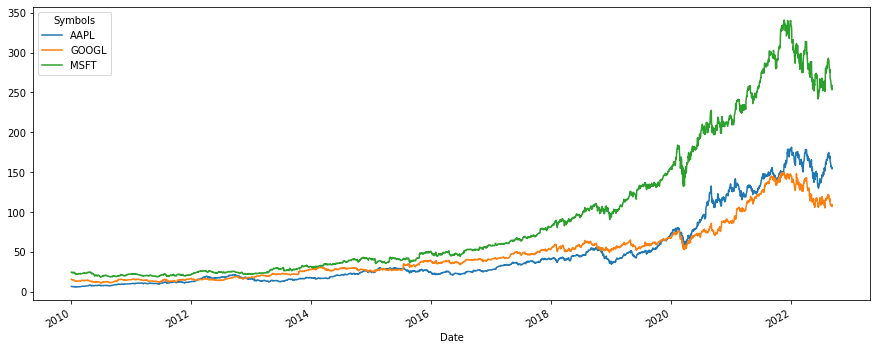

In [24]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

This time we need to make sure to preserve the stock symbol information while reordering:

In [25]:
df_melted = df.copy()
df_melted["Date"] = df_melted.index
df_melted = df_melted.melt(id_vars="Date", value_name="Close").sort_values(["Symbols", "Date"])
df_melted = df_melted[["Symbols", "Date", "Close"]]

df_melted

,Symbols,Date,Close
3192,AAPL,2010-01-04,6.52603
3191,AAPL,2010-01-05,6.53722
3190,AAPL,2010-01-06,6.43286
3189,AAPL,2010-01-07,6.42148
3188,AAPL,2010-01-08,6.46472
...,...,...,...
6390,MSFT,2022-09-01,260.40000
6389,MSFT,2022-09-02,256.06000
6388,MSFT,2022-09-06,253.25000
6387,MSFT,2022-09-07,258.09000


## Create training data sample

In [49]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="Date",
                             max_timeshift=25, min_timeshift=10)

C:\Users\bisha\AppData\Roaming\Python\Python38\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


## Extract Features

In [50]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="Date", column_value="Close", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [03:13<00:00,  9.65s/it]


In [51]:
X.to_csv('../data/v1/features.csv')

We make the data a bit easier to work with by giving them a multi-index instead ot the tuple index:

In [48]:
# split up the two parts of the index and give them proper names
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["Symbols", "Date"]

In [31]:
X.to_csv('../data/v1/')

Close__variance_larger_than_standard_deviation  \
Symbols last_date                                                    
AAPL    2010-01-19                                             0.0   
        2010-01-20                                             0.0   
        2010-01-21                                             0.0   
        2010-01-22                                             0.0   
        2010-01-25                                             0.0   

                    Close__has_duplicate_max  Close__has_duplicate_min  \
Symbols last_date                                                        
AAPL    2010-01-19                       0.0                       0.0   
        2010-01-20                       0.0                       0.0   
        2010-01-21                       0.0                       0.0   
        2010-01-22                       0.0                       0.0   
        2010-01-25                       0.0                       0.0   

                    Close__has_duplicate  Close__sum_values  \
Symbols last_date                                             
AAPL    2010-01-19                   0.0           70.76999   
        2010-01-20                   0.0           77.22662   
        2010-01-21                   0.0           83.57111   
        2010-01-22                   0.0           89.60083   
        2010-01-25                   0.0           95.79363   

                    Close__abs_energy  Close__mean_abs_change  \
Symbols last_date                                               
AAPL    2010-01-19         455.380881                0.081178   
        2010-01-20         497.068952                0.082985   
        2010-01-21         537.321506                0.085415   
        2010-01-22         573.679029                0.103058   
        2010-01-25         612.029801                0.107345   

                    Close__mean_change  Close__mean_second_derivative_central  \
Symbols last_date                                                               
AAPL    2010-01-19            0.003166                               0.014857   
        2010-01-20           -0.006309                              -0.005612   
        2010-01-21           -0.015128                              -0.005606   
        2010-01-22           -0.038178                              -0.013582   
        2010-01-25           -0.023802                               0.005842   

                    Close__median  ...  \
Symbols last_date                  ...   
AAPL    2010-01-19        6.42318  ...   
        2010-01-20        6.42802  ...   
        2010-01-21        6.42318  ...   
        2010-01-22        6.42233  ...   
        2010-01-25        6.42148  ...   

                    Close__permutation_entropy__dimension_6__tau_1  \
Symbols last_date                                                    
AAPL    2010-01-19                                        1.791759   
        2010-01-20                                        1.945910   
        2010-01-21                                        2.079442   
        2010-01-22                                        2.197225   
        2010-01-25                                        2.302585   

                    Close__permutation_entropy__dimension_7__tau_1  \
Symbols last_date                                                    
AAPL    2010-01-19                                        1.609438   
        2010-01-20                                        1.791759   
        2010-01-21                                        1.945910   
        2010-01-22                                        2.079442   
        2010-01-25                                        2.197225   

                    Close__query_similarity_count__query_None__threshold_0.0  \
Symbols last_date                                                              
AAPL    2010-01-19                                                0.0          
        2010-01-20         

Our `(AAPL, 2020-07-14 00:00:00)` is also in the data again:

In [34]:
X.loc["AAPL", pd.to_datetime('2020-07-14')]

Close__variance_larger_than_standard_deviation                1.000000
Close__has_duplicate_max                                      0.000000
Close__has_duplicate_min                                      0.000000
Close__has_duplicate                                          1.000000
Close__sum_values                                          4240.104700
                                                              ...     
Close__matrix_profile__feature_"mean"__threshold_0.98         1.883975
Close__matrix_profile__feature_"median"__threshold_0.98       1.718457
Close__matrix_profile__feature_"25"__threshold_0.98           1.293161
Close__matrix_profile__feature_"75"__threshold_0.98           2.344056
Close__mean_n_absolute_max__number_of_maxima_7               93.854786
Name: (AAPL, 2020-07-14 00:00:00), Length: 789, dtype: float64

Just to repeat: the features in this row were only calculated using the time series values of `AAPL` up to and including `2015-07-15` and the last 20 days.

## Prediction

The next line might look like magic if you are not used to pandas transformations, but what it does is:

for each stock symbol separately:
* sort by date
* take the high value
* shift 1 time step in the future
* bring into the same multi-index format as `X` above

In [35]:
y = df_melted.groupby("Symbols").apply(lambda x: x.set_index("Date")["Close"].shift(-1)).T.unstack()

Quick consistency test:

In [36]:
y["AAPL", pd.to_datetime("2020-07-13")], df.loc[pd.to_datetime("2020-07-14"), "AAPL"]

(95.727, 95.727)

In [37]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [40]:
y

Symbols  Date      
AAPL     2010-01-19      6.45663
         2010-01-20      6.34449
         2010-01-21      6.02972
         2010-01-22      6.19280
         2010-01-25      6.27928
                         ...    
MSFT     2022-09-01    256.06000
         2022-09-02    253.25000
         2022-09-06    258.09000
         2022-09-07    258.52000
         2022-09-08          NaN
Length: 9549, dtype: float64

The splitting into train and test samples workes in principle the same as with a single identifier, but this time we have a multi-index symbol-date, so the `loc` call looks a bit more complicated:

In [38]:
X_train = X.loc[(slice(None), slice(None, "2018")), :]
X_test = X.loc[(slice(None), slice("2019", "2020")), :]

y_train = y.loc[(slice(None), slice(None, "2018"))]
y_test = y.loc[(slice(None), slice("2019", "2020"))]

In [39]:
X_train_selected = select_features(X_train, y_train)

In [44]:
X_train.shape

(6762, 789)

We are training a regressor for each of the stocks separately

In [23]:
adas = {stock: AdaBoostRegressor() for stock in ["AAPL", "F", "GOOGL"]}

for stock, ada in adas.items():
    ada.fit(X_train_selected.loc[stock], y_train.loc[stock])

Now lets check again how good our prediction is:

In [24]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.concat({
    stock: pd.Series(adas[stock].predict(X_test_selected.loc[stock]), index=X_test_selected.loc[stock].index)
    for stock in adas.keys()
})
y_pred.index.names = ["Symbols", "last_date"]

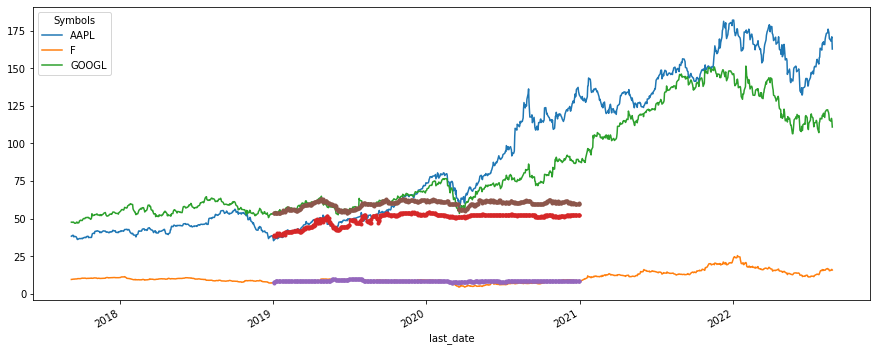

In [25]:
plt.figure(figsize=(15, 6))

y.unstack("Symbols").plot(ax=plt.gca())
y_pred.unstack("Symbols").plot(ax=plt.gca(), legend=None, marker=".")